<a href="https://colab.research.google.com/github/ecandes/stat318/blob/master/Coupling_from_the_Past.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coupling from the Past: the Propp-Wilson algorithm

Imagine we have a Markov chain that we decide to write as 

$$
X_t = f(X_{t-1}, \theta_t).
$$

Below, we will write $f_\theta$ as a shorthand for $f(\cdot, \theta)$ so that we have 

$$
X_t = f_{\theta_t}(X_{t-1})
$$

and, therefore, 

$$
X_t = f_{\theta_t} \circ \ldots \circ f_{\theta_1}(X_0).
$$

### Contraction to a constant mapping

One key idea is that time-reversing leads to the same distribution: that is, if we set 

$$
Y_t =  f_{\theta_1} \circ \ldots \circ f_{\theta_t}(X_0), 
$$ 

then 
$$
X_t \stackrel{d}{=} Y_t.
$$

Having said this, there is a profound difference between $Y_t$ and $X_t$. Indeed, consider the map 

$$
D_t = f_{\theta_1} \circ \ldots \circ f_{\theta_t},
$$

In fact, there is a random time $T$ at which $D_T$ becomes constant. It is clear that for all $t \ge T$, $D_t$ does not move, i.e., $D_t$ is equal to this constant mapping. 

This has an importance consequence. If the Markov chain converges to a stationary distribution in the sense that 

$$
\lim_{t \rightarrow \infty} \mathcal{L}(X_t) = \pi,
$$ 

then we can see that 

$$
\pi = \lim_{t \rightarrow \infty}  \mathcal{L}(Y_t) = \mathcal{L}(Y_T). 
$$

In other words, $Y_T$ is a *perfect* sample from $\pi$. I believe that this implies that $X_T$ is also a *perfect* sample from $\pi$. 

### Ordering

We would need to track when the mapping becomes constant. To do this, we might imagine that we would have to track many trajectories but in some situations this is not the case. There sometimes is a monotonicity property, which lets us track only a small number of states. In the best possible scenario, we would only track a minimal and a maximal state and stop when 

$$
D_t(X_{\text{min}}) = D_t(X_{\text{max}}).
$$

In the case of the Ising model, the two states are all spins down and all spins up. 

The monotonicity property states that for all states $X$ such that 

$$
X_{\text{min}} \le X \le X_{\text{max}}
$$

we have that 

$$
D_t(X_{\text{min}}) \le D_t(X) \le D_t(X_{\text{max}}). 
$$

This is typically proven by induction on $t$. 




## Ising model 

A configuration $I \in \{\pm1\}^{d_1 \times d_2}$ follows the Ising model if the density is of the form 

$$
\pi(I) \propto e^{-\beta E(I)}, 
$$

where the energy is defined as

$$
E(I) = - \sum_{v \sim v'} I_v I_{v'};
$$

above, the sum is taken over the edges of a graph, which we will take as the toric square lattice. The parameter $\beta$ is an inverse temperature parameter. The larger $\beta$ (the lower the temperature), the stronger the alignment. 

There is a famous critical temperature given by 

$$
\beta_c = \log(\sqrt{2} + 1)/2 \approx 0.44. 
$$

We want to simulate Ising models at warmer temperatures, i.e. for values of $\beta$ obeying $\beta < \beta_c$. 

In [0]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [0]:
class IsingModel:

    def __init__(self, G):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        self.nodes_tolist = dict(zip(self.nodes,range(self.n)))
        self.Xmax =  np.ones(self.n,dtype=int)
        self.Xmin = -np.ones(self.n,dtype=int)
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def getNeighbors(self,v):
        return [self.nodes_tolist[w] for w in self.G.neighbors(self.nodes[v])]

    def sumNeighbors(self, X, v):
        return np.array([X[w] for w in self.getNeighbors(v)]).sum()

    def GibbsUpdate(self,X,v,theta,beta):
      prob =  1/(1 + np.exp(-2*beta*self.sumNeighbors(X,v))) 
      X[v] = 1 if theta < prob else -1

    def ProppWilson(self,beta):
      
      def updateSites(siteList,nsteps):
        new_list = np.random.choice(self.n, nsteps, replace=True)
        siteList.extend(new_list)
        
      def updateThetas(thetaList,nsteps):
        thetaList.extend(list(np.random.rand(nsteps)))
        
      nsteps = 1
      siteList, thetaList = [], []
      
      print('Steps: ', end = " ")
      while not np.array_equal(self.Xmax, self.Xmin):
        print(int(np.log2(nsteps)), end = " ")
        # Sample new vertices that will be updated  
        updateSites(siteList,nsteps)
        # Toss new coins to flip signs 
        updateThetas(thetaList,nsteps)
        # Perform Gibbs update 
        for site, theta in zip(siteList[::-1],thetaList[::-1]):
            self.GibbsUpdate(self.Xmax,site,theta,beta)
            self.GibbsUpdate(self.Xmin,site,theta,beta)
        
        nsteps *= 2 
    
    def drawConfig(self, X, **options):
        up =   [self.nodes[v] for v in range(self.n) if X[v] ==  1]
        down = [self.nodes[v] for v in range(self.n) if X[v] == -1] 
        nx.draw(G, self.pos, nodelist=up, node_color="b", **options)
        nx.draw(G, self.pos, nodelist=down, node_color="r", **options)
        plt.title('Ising model configuration')
        plt.show()


In [0]:
L = 10
G = nx.grid_2d_graph(L,L)
chain = IsingModel(G)
beta = 1/3
# plt.rcParams["figure.figsize"] = (4,4)
chain.ProppWilson(beta)

Steps:  0 1 2 3 4 5 6 7 8 9 10 11 

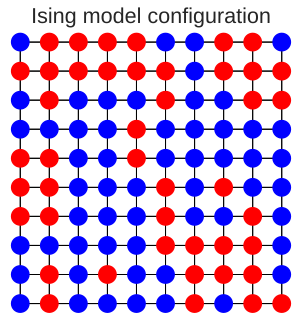

In [0]:
chain.drawConfig(chain.Xmin)

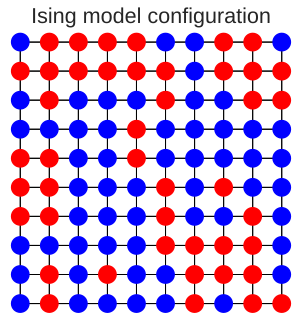

In [0]:
chain.drawConfig(chain.Xmax)

In [0]:
%%time
L = 100
G = nx.grid_2d_graph(L,L)
chain = IsingModel(G)
beta = 1/3
# plt.rcParams["figure.figsize"] = (4,4)
chain.ProppWilson(beta)

Steps:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 CPU times: user 57.5 s, sys: 80.5 ms, total: 57.6 s
Wall time: 57.6 s


In [0]:
fig = plt.figure()
fig.set_figheight(6) 
fig.set_figwidth(6)
options = {'node_size' : 8, 'width' : 1}
chain.drawConfig(chain.Xmin,**options)